In [1]:
%load_ext autoreload
%autoreload 2
from dataloader import get_dataset
from config import get_default_config
from anchors import Anchor
from utils import ltrb2xywh, xywh2ltrb

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
config = get_default_config()

In [5]:
ds, step_per_epoch_train = get_dataset(config, 'train')

In [6]:
ds_valid, _ = get_dataset(config, 'valid')

In [7]:
for img, cat, box in ds.take(1):
    print(img.shape, cat.shape, box.shape)

(8, 512, 512, 3) (8, 49104) (8, 49104, 4)


In [8]:
for img, cat, box in ds_valid.take(1):
    print(img.shape, cat.shape, box.shape)

(16, 512, 512, 3) (16, 49104) (16, 49104, 4)


In [9]:
from train_lib import get_optimizer, EffDetTrainer

In [10]:
from loss import BoxLoss, FocalLoss

In [11]:
config.update('step_per_epoch', step_per_epoch_train)

In [12]:
opt = get_optimizer(config)

In [13]:
cls_loss = FocalLoss(.25, 1.5)
box_loss = BoxLoss(.1)

In [14]:
effdet = EffDetTrainer(config)

In [15]:
effdet.compile(optimizer=get_optimizer(config),
              loss={
                  'cls_loss': cls_loss,
                  'box_loss': box_loss,
              })

In [16]:
effdet.build((1, 512, 512, 3))
effdet.summary()

Model: "eff_det_trainer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      [(None, 256, 256, 16), (N 3634844   
_________________________________________________________________
bi_fpns (BiFPNS)             multiple                  200121    
_________________________________________________________________
class_net (ClassNet)         multiple                  30324     
_________________________________________________________________
box_net (BoxNet)             multiple                  20964     
Total params: 3,886,253
Trainable params: 243,729
Non-trainable params: 3,642,524
_________________________________________________________________


In [17]:
effdet.fit(x=ds,
           epochs=config.epoch_total, validation_data=ds_valid)

Epoch 1/100
    182/Unknown - 29s 159ms/step - cls_loss: 1.2517 - box_loss: 0.0125 - total_loss: 1.8764

KeyboardInterrupt: 

In [41]:
box_pred = effdet(img, training=True)

In [42]:
box_pred = box_pred[1]

In [43]:
pos_indi = tf.cast(tf.not_equal(cat, -1), tf.float32)

In [44]:
tf.reduce_sum(pos_indi)

<tf.Tensor: shape=(), dtype=float32, numpy=567.0>

In [45]:
tf.reduce_sum(tf.keras.losses.Huber(delta=.1, reduction=tf.keras.losses.Reduction.NONE)(box, box_pred) * pos_indi)

<tf.Tensor: shape=(), dtype=float32, numpy=8.796929>

In [46]:
8.796/(567*4)

0.003878306878306878

----------------------
----------------------
# notepad

----------------------

In [1]:
%load_ext autoreload
%autoreload 2
from dataloader import get_dataset
from config import get_default_config
from anchors import Anchor
from utils import ltrb2xywh, xywh2ltrb

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import decode_predictions

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
config = get_default_config()

In [6]:
config.update('input_size', (224, 224))

In [7]:
from backbone import *

In [8]:
backbone_config = get_effnet_params(config)
backbone = build_effnet(backbone_config, feature_only=False, name=config.backbone_name)

In [ ]:
backbone.summary()

In [9]:
backbone.build((1, 224, 224, 3))

In [9]:
backbone.load_weights('../model/efficientnet_weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment.h5')

In [10]:
backbone.input_shape

(None, 224, 224, 3)

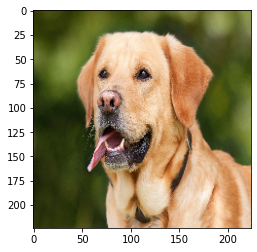

In [11]:
dog = cv2.imread('dog1.jpg')[..., ::-1]

dog = cv2.resize(dog, (224, 224))
plt.imshow(dog)
plt.show()

In [12]:
dog_norm = dog / 255.
result = backbone(dog_norm[tf.newaxis, ...], training=False)
result.shape

TensorShape([1, 1000])

In [13]:
decode_predictions(result.numpy())

[[('n02099712', 'Labrador_retriever', 0.68459713),
  ('n02087394', 'Rhodesian_ridgeback', 0.026737219),
  ('n02108422', 'bull_mastiff', 0.023591056),
  ('n02099601', 'golden_retriever', 0.021849759),
  ('n02088466', 'bloodhound', 0.018787563)]]

In [30]:
backbone.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (SyncBatchNormalization (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [29]:
decode_predictions(result.numpy())

[[('n03930313', 'picket_fence', 1.3370821),
  ('n04209239', 'shower_curtain', 1.2527745),
  ('n03530642', 'honeycomb', 1.1932482),
  ('n01734418', 'king_snake', 1.1675622),
  ('n03733281', 'maze', 1.1517532)]]

In [28]:
no = np.argmax(result, axis=-1)
print(no)

[716]


In [30]:
result[0][716]

<tf.Tensor: shape=(), dtype=float32, numpy=1.3370821>

In [31]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [32]:
imagenet_labels = imagenet_labels[1:]

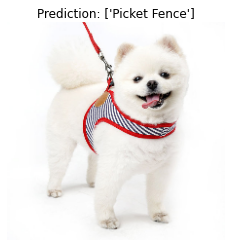

In [33]:
plt.imshow(dog)
plt.axis('off')
predicted_class_name = str(imagenet_labels[no])
_ = plt.title("Prediction: " + predicted_class_name.title())